# Explorative Analysis on Formala 1 Predictive Modeling

### Import packages

In [394]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from hyperopt import STATUS_OK
import joblib
print("Packages imported")

Packages imported


#### Import dataset

In [395]:
openf1_data_df = pd.read_csv("openf1_data.csv")

### Splits + Random seed

In [396]:
n_splits = 8
random_seed = 42

### Preprocess data

In [397]:
from preprocessing import preprocessing

#preprocess data
preprocessed_data = preprocessing(openf1_data_df)

#Class names for the target variable
class_names = {
    -1: "Didn't race",
    1: "Win",
    2: "Podium",
    3: "Top 7",
    4: "Top 10",
    5: "No points"
}

#Number of classes for the target variable
num_classes = len(class_names)

#List of numerical features
numerical_features = ["Session_1_starting_wind_direction",
                      "Session_1_starting_wind_speed",
                      "Session_1_starting_rainfall",
                      "Session_1_starting_track_temperature",
                      "Session_1_starting_air_temperature",
                      "Session_1_starting_humidity",
                      "Session_1_starting_pressure",
                      "Session_1_ending_wind_direction",
                      "Session_1_ending_wind_speed",
                      "Session_1_ending_rainfall",
                      "Session_1_ending_track_temperature",
                      "Session_1_ending_air_temperature",
                      "Session_1_ending_humidity",
                      "Session_1_ending_pressure",
                      "Session_2_starting_wind_direction",
                      "Session_2_starting_wind_speed",
                      "Session_2_starting_rainfall",
                      "Session_2_starting_track_temperature",
                      "Session_2_starting_air_temperature",
                      "Session_2_starting_humidity",
                      "Session_2_starting_pressure",
                      "Session_2_ending_wind_direction",
                      "Session_2_ending_wind_speed",
                      "Session_2_ending_rainfall",
                      "Session_2_ending_track_temperature",
                      "Session_2_ending_air_temperature",
                      "Session_2_ending_humidity",
                      "Session_2_ending_pressure",
                      "Session_3_starting_wind_direction",
                      "Session_3_starting_wind_speed",
                      "Session_3_starting_rainfall",
                      "Session_3_starting_track_temperature",
                      "Session_3_starting_air_temperature",
                      "Session_3_starting_humidity",
                      "Session_3_starting_pressure",
                      "Session_3_ending_wind_direction",
                      "Session_3_ending_wind_speed",
                      "Session_3_ending_rainfall",
                      "Session_3_ending_track_temperature",
                      "Session_3_ending_air_temperature",
                      "Session_3_ending_humidity",
                      "Session_3_ending_pressure",
                      "Session_4_starting_wind_direction",
                      "Session_4_starting_wind_speed",
                      "Session_4_starting_rainfall",
                      "Session_4_starting_track_temperature",
                      "Session_4_starting_air_temperature",
                      "Session_4_starting_humidity",
                      "Session_4_starting_pressure",
                      "Session_4_ending_wind_direction",
                      "Session_4_ending_wind_speed",
                      "Session_4_ending_rainfall",
                      "Session_4_ending_track_temperature",
                      "Session_4_ending_air_temperature",
                      "Session_4_ending_humidity",
                      "Session_4_ending_pressure",
                      "Session_5_starting_wind_direction",
                      "Session_5_starting_wind_speed",
                      "Session_5_starting_rainfall",
                      "Session_5_starting_track_temperature",
                      "Session_5_starting_air_temperature",
                      "Session_5_starting_humidity",
                      "Session_5_starting_pressure"]

#List of categorical features
categorical_features = [
                        "team_id",
                        "driver_number",
                        "circuit_key",
                        "Session_1_session_type_id",
                        "Session_2_session_type_id",
                        "Session_3_session_type_id",
                        "Session_4_session_type_id",
                        "Session_5_session_type_id",
                        "Session_1_position",
                        "Session_2_position",
                        "Session_3_position",
                        "Session_4_position",
                        "Session_1_is_seat_driver",
                        "Session_2_is_seat_driver",
                        "Session_3_is_seat_driver",
                        "Session_4_is_seat_driver",
                        "Session_5_is_seat_driver",
                        "Sprint Wknd",
                        "Race Wknd",
                        "Preseason Wknd"]

#Split data into features and target
X = preprocessed_data[0]
y = preprocessed_data[1]

/Users/anthony/Documents/CS/Coding/F1 project/preprocessing.py:226: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df[feature].fillna(method='bfill', inplace=True)
/Users/anthony/Documents/CS/Coding/F1 project/preprocessing.py:226: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_df[feature].fillna(method='bfill', inplace=True)
/Users/anthony/Documents/CS/Coding/F1 project/preprocessing.py:226: FutureWarning: A value is trying to be 

In [398]:
#Function to get train and test sets for each fold
def get_train_test_set(X, y, idx, label_encoder):
    train_idx, test_idx = idx
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    y_train, y_test = label_encoder.fit_transform(y_train), label_encoder.transform(y_test)
    return X_train, X_test, y_train, y_test

#Time series cross validation
tscv = TimeSeriesSplit(n_splits=n_splits)

## Tracking model performance

In [399]:
columns = ["Model Type", "Weighted AUC"]
columns.extend(class_names.values())
model_performance_df = pd.DataFrame(columns=columns)
model_performance_df

,Model Type,Weighted AUC,Didn't race,Win,Podium,Top 7,Top 10,No points


Function to get final fold metrics

In [400]:
#Get metrics for final fold
def final_fold_metrics(y_test, y_pred, y_pred_proba, model_type):
    global model_performance_df

    class_metrics = classification_report(y_test, y_pred, target_names=class_names.values()) 
    columns = ["Model Type", "Weighted AUC"]
    columns.extend(class_names.values())
    auc_df = pd.DataFrame(columns=columns)
    # Get AUC scores for each class in final fold
    y_test_binary = np.zeros((len(y_test), num_classes))
    for i in range(num_classes):
        y_test_binary[:, i] = (y_test == i).astype(int)
    
    for i in range(num_classes):
        class_auc = roc_auc_score(y_test_binary[:, i], y_pred_proba[:, i])
        class_name = list(class_names.values())[i]
        auc_df[class_name] = [class_auc]
    auc_df["Model Type"] = [model_type]
    weighted_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_df["Weighted AUC"] = [weighted_auc]
    model_performance_df = pd.concat([model_performance_df, auc_df])
    return auc_df, class_metrics

## Training the model

Model training

In [401]:
#Function to train the model
def model_training(X, y, split_indices, model, model_type, use_sample_weights = True): #Sample weights for XGBoost
    le = LabelEncoder() #XGboost requires encoded target variable
    print("Training model...")
    for fold, idx in enumerate(split_indices): #Split data into train and test sets for each fold, and train on training set
        print(f"Fold {fold + 1}...")
        X_train, X_test, y_train, y_test = get_train_test_set(X, y, idx, le)
        if use_sample_weights:
            class_weights = compute_class_weight( #Compute class weights to account for class imbalance
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(zip(np.unique(y_train), class_weights)) #Create dictionary of class weights
            sample_weights = np.array([class_weights_dict[i] for i in y_train]) #Create array of sample weights
            model.fit(X_train, y_train, classifier__sample_weight=sample_weights) #Train model on training set with sample weights
        else:
            model.fit(X_train, y_train) #Train model on training set without sample weights
        
        y_pred = model.predict(X_test) #Predict on test set
        y_pred_proba = model.predict_proba(X_test) #Predict probabilities on test set
        fold_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted') #Calculate AUC score
        fold_accuracy = accuracy_score(y_test, y_pred) #Calculate accuracy score
        print(f"Fold {fold + 1} AUC: {fold_auc}")
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy}")
    #Get metrics for final fold
    class_aucs, class_metrics = final_fold_metrics(y_test, y_pred, y_pred_proba, model_type)
    print(f"Final Fold Classification Report: \n{class_metrics}")
    print(f"Final Fold AUC: {class_aucs}")

Column transformer

In [402]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## First looking at RandomForest with SMOTE

In [403]:
from sklearn.ensemble import RandomForestClassifier

In [404]:
RandomForestPipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # Resample the minority class
    ('classifier', RandomForestClassifier(random_state=42))
])


model_training(X, y, tscv.split(X), RandomForestPipeline, use_sample_weights = False, model_type = "Random Forest with SMOTE")

Training model...
Fold 1...
Fold 1 AUC: 0.7287958574496113
Fold 1 Accuracy: 0.5
Fold 2...
Fold 2 AUC: 0.7755457544393826
Fold 2 Accuracy: 0.5579710144927537
Fold 3...
Fold 3 AUC: 0.8597970610899608
Fold 3 Accuracy: 0.5869565217391305
Fold 4...
Fold 4 AUC: 0.8397471207717511
Fold 4 Accuracy: 0.6304347826086957
Fold 5...
Fold 5 AUC: 0.833206729806639
Fold 5 Accuracy: 0.6014492753623188
Fold 6...
Fold 6 AUC: 0.8085240581881239
Fold 6 Accuracy: 0.5507246376811594
Fold 7...
Fold 7 AUC: 0.862838189834743
Fold 7 Accuracy: 0.6811594202898551
Fold 8...
Fold 8 AUC: 0.7994870458113111
Fold 8 Accuracy: 0.6231884057971014
Final Fold Classification Report: 
              precision    recall  f1-score   support

 Didn't race       1.00      0.89      0.94         9
         Win       0.29      0.29      0.29         7
      Podium       0.42      0.38      0.40        13
       Top 7       0.54      0.60      0.57        25
      Top 10       0.17      0.05      0.07        21
   No points       0.71

/var/folders/7t/37ty1g8j1652356k81qf2lv80000gn/T/ipykernel_22836/889499005.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_performance_df = pd.concat([model_performance_df, auc_df])


## Looking at RandomForest with class weights

In [405]:
RandomForestPipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

model_training(X, y, tscv.split(X), RandomForestPipeline, use_sample_weights = True, model_type = "Random Forest with Class Balancing")

Training model...
Fold 1...
Fold 1 AUC: 0.721139135948544
Fold 1 Accuracy: 0.4927536231884058
Fold 2...
Fold 2 AUC: 0.7877812481464551
Fold 2 Accuracy: 0.5797101449275363
Fold 3...
Fold 3 AUC: 0.8522598940833735
Fold 3 Accuracy: 0.5652173913043478
Fold 4...
Fold 4 AUC: 0.8385367100686352
Fold 4 Accuracy: 0.6304347826086957
Fold 5...
Fold 5 AUC: 0.8136121994224668
Fold 5 Accuracy: 0.6231884057971014
Fold 6...
Fold 6 AUC: 0.8029800320106427
Fold 6 Accuracy: 0.6014492753623188
Fold 7...
Fold 7 AUC: 0.8473987704151816
Fold 7 Accuracy: 0.6811594202898551
Fold 8...
Fold 8 AUC: 0.7796798352371634
Fold 8 Accuracy: 0.6304347826086957
Final Fold Classification Report: 
              precision    recall  f1-score   support

 Didn't race       1.00      0.89      0.94         9
         Win       0.40      0.29      0.33         7
      Podium       0.50      0.31      0.38        13
       Top 7       0.43      0.60      0.50        25
      Top 10       0.00      0.00      0.00        21
   No p

/Users/anthony/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anthony/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anthony/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

## Looking at RandomForest with both class weights and smote

In [406]:
RandomForestPipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

model_training(X, y, tscv.split(X), RandomForestPipeline, use_sample_weights = False, model_type = "Random Forest with SMOTE & Class Balancing")

Training model...
Fold 1...
Fold 1 AUC: 0.7287958574496113
Fold 1 Accuracy: 0.5
Fold 2...
Fold 2 AUC: 0.7755457544393826
Fold 2 Accuracy: 0.5579710144927537
Fold 3...
Fold 3 AUC: 0.8597970610899608
Fold 3 Accuracy: 0.5869565217391305
Fold 4...
Fold 4 AUC: 0.8397471207717511
Fold 4 Accuracy: 0.6304347826086957
Fold 5...
Fold 5 AUC: 0.833206729806639
Fold 5 Accuracy: 0.6014492753623188
Fold 6...
Fold 6 AUC: 0.8085240581881239
Fold 6 Accuracy: 0.5507246376811594
Fold 7...
Fold 7 AUC: 0.862838189834743
Fold 7 Accuracy: 0.6811594202898551
Fold 8...
Fold 8 AUC: 0.7994870458113111
Fold 8 Accuracy: 0.6231884057971014
Final Fold Classification Report: 
              precision    recall  f1-score   support

 Didn't race       1.00      0.89      0.94         9
         Win       0.29      0.29      0.29         7
      Podium       0.42      0.38      0.40        13
       Top 7       0.54      0.60      0.57        25
      Top 10       0.17      0.05      0.07        21
   No points       0.71

## Looking at XGBoost with SMOTE

In [407]:
XGBoostPipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=num_classes,
        eval_metric='mlogloss',
        random_state= random_seed
    ))
])

model_training(X, y, tscv.split(X), XGBoostPipeline, use_sample_weights = False, model_type = "XGBoost with SMOTE")

Training model...
Fold 1...
Fold 1 AUC: 0.6652451618696517
Fold 1 Accuracy: 0.4855072463768116
Fold 2...
Fold 2 AUC: 0.7899310216369917
Fold 2 Accuracy: 0.6014492753623188
Fold 3...
Fold 3 AUC: 0.889929569567741
Fold 3 Accuracy: 0.6666666666666666
Fold 4...
Fold 4 AUC: 0.8374632783757563
Fold 4 Accuracy: 0.6159420289855072
Fold 5...
Fold 5 AUC: 0.82190601281951
Fold 5 Accuracy: 0.6086956521739131
Fold 6...
Fold 6 AUC: 0.809216895494297
Fold 6 Accuracy: 0.572463768115942
Fold 7...
Fold 7 AUC: 0.8765277163650854
Fold 7 Accuracy: 0.6594202898550725
Fold 8...
Fold 8 AUC: 0.8339694940214082
Fold 8 Accuracy: 0.5652173913043478
Final Fold Classification Report: 
              precision    recall  f1-score   support

 Didn't race       1.00      0.89      0.94         9
         Win       0.33      0.29      0.31         7
      Podium       0.40      0.31      0.35        13
       Top 7       0.40      0.40      0.40        25
      Top 10       0.07      0.05      0.06        21
   No point

## Looking at XGBoost with Balanced class weights

In [408]:
XGBoostPipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=num_classes,
        eval_metric='mlogloss',
        random_state= random_seed
    ))
])

model_training(X, y, tscv.split(X), XGBoostPipeline, use_sample_weights = True, model_type = "XGBoost with sample weights")

Training model...
Fold 1...
Fold 1 AUC: 0.6684642875642409
Fold 1 Accuracy: 0.4855072463768116
Fold 2...
Fold 2 AUC: 0.7730537103498498
Fold 2 Accuracy: 0.5797101449275363
Fold 3...
Fold 3 AUC: 0.8884283171797336
Fold 3 Accuracy: 0.6956521739130435
Fold 4...
Fold 4 AUC: 0.8241254508839387
Fold 4 Accuracy: 0.5942028985507246
Fold 5...
Fold 5 AUC: 0.8036634531870073
Fold 5 Accuracy: 0.6014492753623188
Fold 6...
Fold 6 AUC: 0.7981525056987515
Fold 6 Accuracy: 0.5362318840579711
Fold 7...
Fold 7 AUC: 0.8812000198083182
Fold 7 Accuracy: 0.6521739130434783
Fold 8...
Fold 8 AUC: 0.8369814611488043
Fold 8 Accuracy: 0.6231884057971014
Final Fold Classification Report: 
              precision    recall  f1-score   support

 Didn't race       1.00      0.89      0.94         9
         Win       0.43      0.43      0.43         7
      Podium       0.50      0.38      0.43        13
       Top 7       0.43      0.52      0.47        25
      Top 10       0.29      0.24      0.26        21
   No 

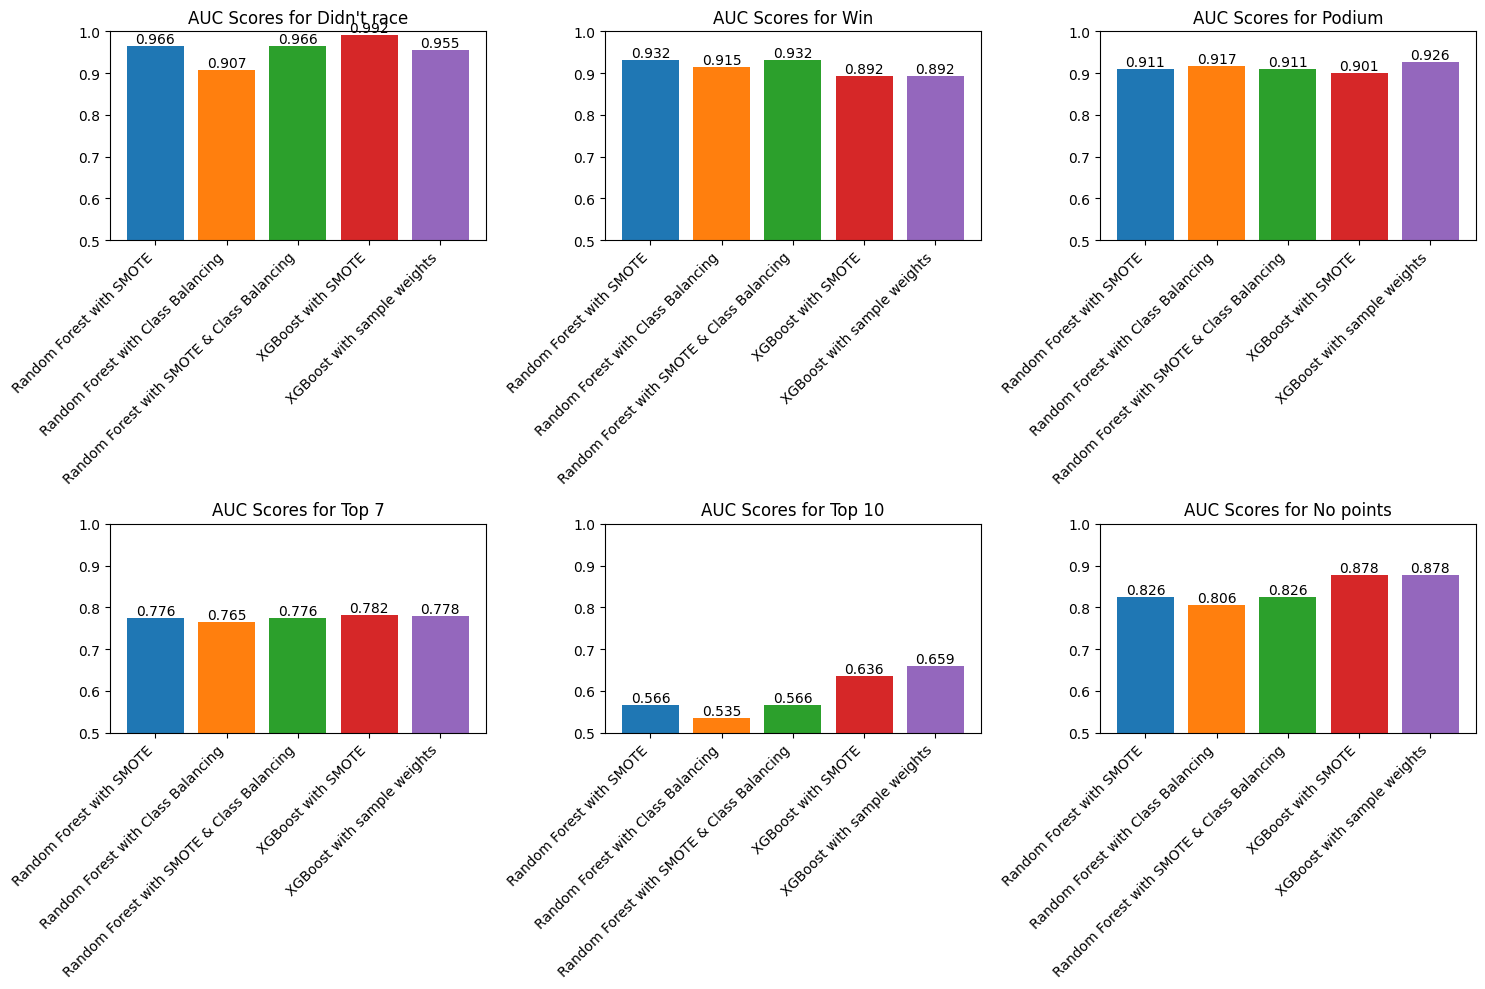

In [409]:
model_performance_df
# Set up the figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Define colors for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot histogram for each class
for i, class_name in enumerate(class_names.values()):
    bars = axes[i].bar(range(len(model_performance_df)), 
                      model_performance_df[class_name],
                      color=colors[:len(model_performance_df)])
    axes[i].set_title(f'AUC Scores for {class_name}')
    axes[i].set_xticks(range(len(model_performance_df)))
    axes[i].set_xticklabels(model_performance_df['Model Type'], rotation=45, ha='right')
    axes[i].set_ylim(0.5, 1)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Trying tuned XGBoost with sample weights

In [410]:
from hyperopt import hp
from hyperopt.fmin import fmin
from hyperopt import tpe
from hyperopt import Trials

In [411]:
def training_model_tuning(X, y, tscv, clf):
    le = LabelEncoder()
    scores = []
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"Fold {fold + 1}...")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        y_train = le.fit_transform(y_train) 

        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )

        class_weights_dict = dict(zip(np.unique(y_train), class_weights))
        sample_weights = np.array([class_weights_dict[i] for i in y_train])

        clf.fit(X_train, y_train, classifier__verbose=False, classifier__sample_weight=sample_weights)
        pred_proba = clf.predict_proba(X_test)
        auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
        scores.append(auc)
    avg_auc = sum(scores) / len(scores)
    print ("AUC:", avg_auc)
    return {'loss': -avg_auc, 'status': STATUS_OK }

In [412]:
space= {
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 100)
    }

def objective(space):
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            enable_categorical = True,
            num_class = num_classes,
            objective = 'multi:softmax',
            n_estimators = int(space['n_estimators']), 
            max_depth = int(space['max_depth']), 
            gamma = space['gamma'],
            reg_alpha = int(space['reg_alpha']),
            min_child_weight=int(space['min_child_weight']),
            colsample_bytree=space['colsample_bytree'],
            random_state = 42,
            eval_metric='auc'
        ))
    ])
    return training_model_tuning(X, y, tscv, clf)

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

Fold 1...                                              
Fold 2...                                              
Fold 3...                                              
Fold 4...                                              
Fold 5...                                              
Fold 6...                                              
Fold 7...                                              
Fold 8...                                              
AUC:                                                   
0.570870155344982                                      
Fold 1...                                                                        
Fold 2...                                                                        
Fold 3...                                                                        
Fold 4...                                                                        
Fold 5...                                                                        
Fold 6...                     

In [413]:
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        enable_categorical = True,
        n_estimators = int(best_hyperparams['n_estimators']),
        colsample_bytree = best_hyperparams['colsample_bytree'],
        max_depth = int(best_hyperparams['max_depth']),
        gamma = int(best_hyperparams['gamma']),
        reg_alpha = int(best_hyperparams['reg_alpha']),
        min_child_weight = int(best_hyperparams['min_child_weight']),
        random_state = 42,
        eval_metric='auc'
    ))
])

model_training(X, y, tscv.split(X), model, use_sample_weights = True, model_type = "Tuned XGBoost with sample weights")

Training model...
Fold 1...
Fold 1 AUC: 0.5
Fold 1 Accuracy: 0.11594202898550725
Fold 2...
Fold 2 AUC: 0.5
Fold 2 Accuracy: 0.043478260869565216
Fold 3...
Fold 3 AUC: 0.7783101367686517
Fold 3 Accuracy: 0.32608695652173914
Fold 4...
Fold 4 AUC: 0.5868715460633861
Fold 4 Accuracy: 0.13043478260869565
Fold 5...
Fold 5 AUC: 0.6251509250088679
Fold 5 Accuracy: 0.15217391304347827
Fold 6...
Fold 6 AUC: 0.6798345535149842
Fold 6 Accuracy: 0.34782608695652173
Fold 7...
Fold 7 AUC: 0.7954217611298338
Fold 7 Accuracy: 0.42028985507246375
Fold 8...
Fold 8 AUC: 0.673478387888106
Fold 8 Accuracy: 0.26811594202898553
Final Fold Classification Report: 
              precision    recall  f1-score   support

 Didn't race       1.00      0.89      0.94         9
         Win       0.45      0.71      0.56         7
      Podium       0.10      0.77      0.18        13
       Top 7       0.00      0.00      0.00        25
      Top 10       0.00      0.00      0.00        21
   No points       0.67     

/Users/anthony/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anthony/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anthony/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

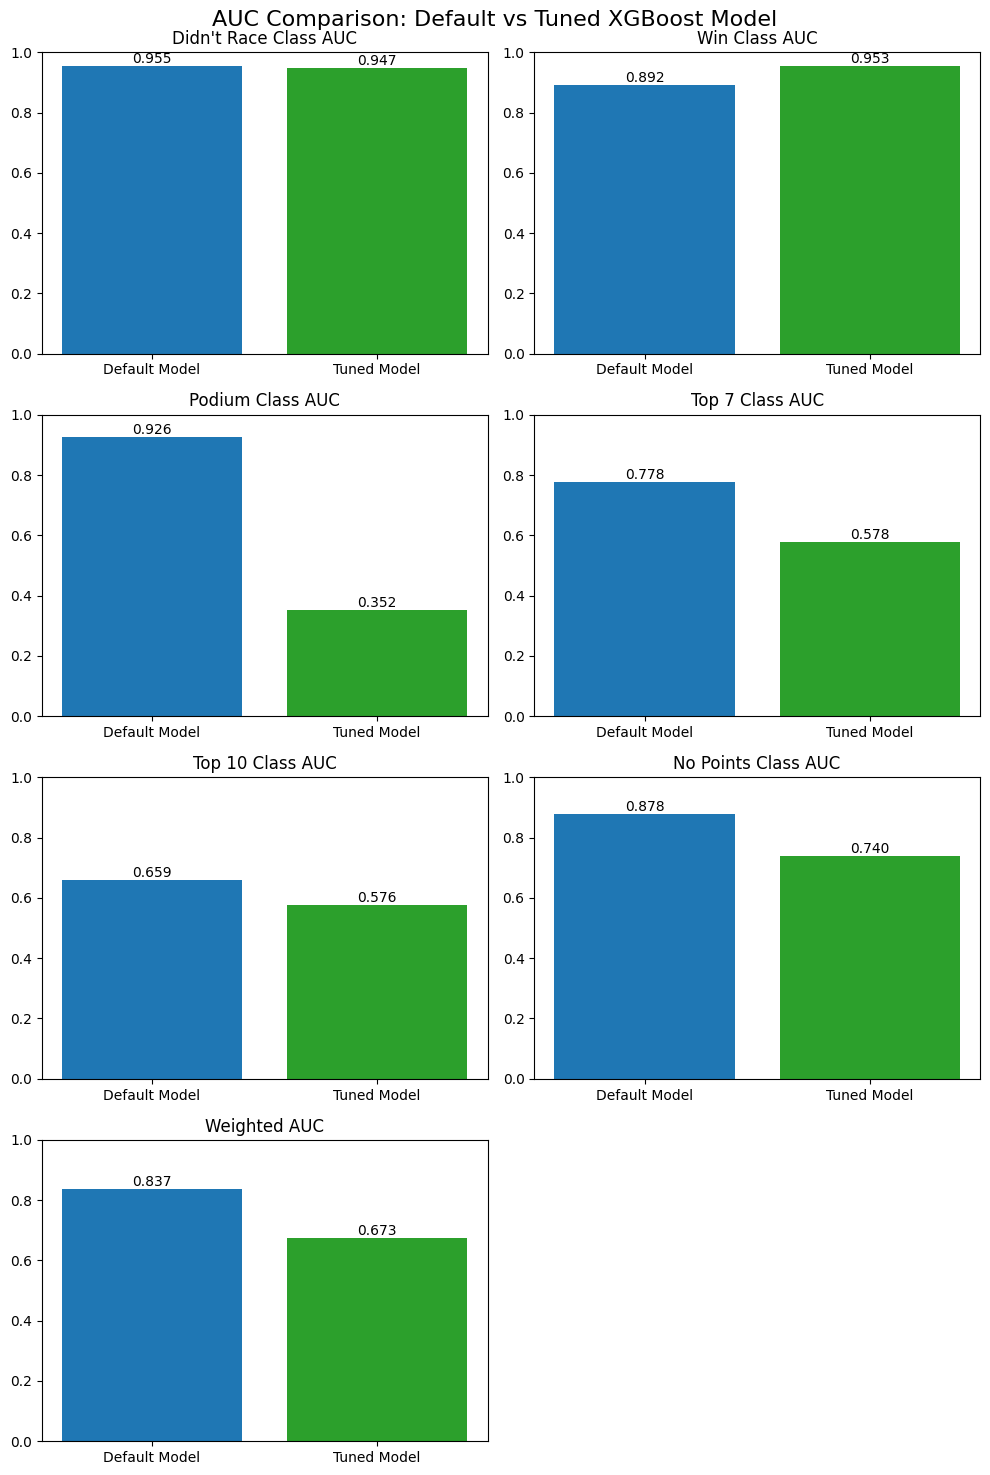

In [414]:
default_model_didnt_race_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['Didn\'t race']
tuned_model_didnt_race_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['Didn\'t race']

default_model_win_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['Win']
tuned_model_win_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['Win']

default_model_podium_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['Podium']
tuned_model_podium_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['Podium']

default_model_top_7_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['Top 7']
tuned_model_top_7_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['Top 7']

default_model_top_10_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['Top 10']
tuned_model_top_10_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['Top 10']

default_model_no_points_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['No points']
tuned_model_no_points_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['No points']

default_model_auc = model_performance_df[model_performance_df['Model Type'] == 'XGBoost with sample weights']['Weighted AUC']
tuned_model_auc = model_performance_df[model_performance_df['Model Type'] == 'Tuned XGBoost with sample weights']['Weighted AUC']

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
fig.suptitle('AUC Comparison: Default vs Tuned XGBoost Model', fontsize=16)

# Define colors
default_color = '#1f77b4'  # Blue
tuned_color = '#2ca02c'    # Green

# Didn't Race plot
axes[0,0].bar(['Default Model', 'Tuned Model'], 
              [default_model_didnt_race_auc.iloc[0], tuned_model_didnt_race_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[0,0].set_title("Didn't Race Class AUC")
axes[0,0].set_ylim(0, 1)

# Win plot              
axes[0,1].bar(['Default Model', 'Tuned Model'],
              [default_model_win_auc.iloc[0], tuned_model_win_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[0,1].set_title("Win Class AUC")
axes[0,1].set_ylim(0, 1)

# Podium plot
axes[1,0].bar(['Default Model', 'Tuned Model'],
              [default_model_podium_auc.iloc[0], tuned_model_podium_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[1,0].set_title("Podium Class AUC")
axes[1,0].set_ylim(0, 1)

# Top 7 plot
axes[1,1].bar(['Default Model', 'Tuned Model'],
              [default_model_top_7_auc.iloc[0], tuned_model_top_7_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[1,1].set_title("Top 7 Class AUC")
axes[1,1].set_ylim(0, 1)

# Top 10 plot
axes[2,0].bar(['Default Model', 'Tuned Model'],
              [default_model_top_10_auc.iloc[0], tuned_model_top_10_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[2,0].set_title("Top 10 Class AUC")
axes[2,0].set_ylim(0, 1)

# No points plot
axes[2,1].bar(['Default Model', 'Tuned Model'],
              [default_model_no_points_auc.iloc[0], tuned_model_no_points_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[2,1].set_title("No Points Class AUC")
axes[2,1].set_ylim(0, 1)

# Weighted AUC plot
axes[3,0].bar(['Default Model', 'Tuned Model'],
              [default_model_auc.iloc[0], tuned_model_auc.iloc[0]],
              color=[default_color, tuned_color])
axes[3,0].set_title("Weighted AUC")
axes[3,0].set_ylim(0, 1)

# Add value labels on top of each bar
def add_value_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

# Apply to each subplot
add_value_labels(axes[0,0])  # Didn't Race
add_value_labels(axes[0,1])  # Win
add_value_labels(axes[1,0])  # Podium  
add_value_labels(axes[1,1])  # Top 7
add_value_labels(axes[2,0])  # Top 10
add_value_labels(axes[2,1])  # No points
add_value_labels(axes[3,0])  # Weighted AUC

# Remove empty subplot
fig.delaxes(axes[3,1])
plt.tight_layout()

plt.show()
